In [1]:
""" initialize notebook """
%matplotlib inline
import matplotlib as mpl
import pylab as PP
import xarray as xr
import numpy as np
import metpy.interpolate
import cartopy

# set some constants
Rd = 287.058
cpd = 1005.7
delta = 0.608
grav = 9.81

mpl.style.use("seaborn-poster")

In [2]:
""" Open model output files """
atm_xr = xr.open_dataset("../means/fog_ctd_control_ATM.200007.nc").isel(jx = slice(12,-12), iy = slice(12,-12), time = 0)
atm_pl_xr = xr.open_dataset("../means/fog_ctd_control_ATM.20000701_pressure.nc").isel(jx = slice(12,-12), iy = slice(12,-12), time = 0)
srf_xr = xr.open_dataset("../means/fog_ctd_control_SRF.200007.nc").isel(jx = slice(12,-12), iy = slice(12,-12), time = 0)
rad_xr = xr.open_dataset("../means/fog_ctd_control_RAD.200007.nc").isel(jx = slice(12,-12), iy = slice(12,-12), time = 0)
rad_pl_xr = xr.open_dataset("../means/fog_ctd_control_RAD.200007_pressure.nc").isel(jx = slice(12,-12), iy = slice(12,-12), time = 0)
dom_xr = xr.open_dataset("../input/fog_ctd_control_DOMAIN000.nc").isel(jx = slice(14,-13), iy = slice(14,-13))

In [3]:
""" Set the projection of the model run, for plotting purposes"""
rcrs = atm_pl_xr['crs'].attrs
globe = cartopy.crs.Globe(ellipse='sphere',
                          semimajor_axis = rcrs['semi_major_axis'],
                          semiminor_axis = rcrs['semi_major_axis'])
#rcm_crs = cartopy.crs.CRS(lu_xr['crs'].attrs['proj4_params'])
rcm_crs = cartopy.crs.LambertConformal(central_longitude = rcrs['longitude_of_central_meridian'],
                                       central_latitude  = rcrs['latitude_of_projection_origin'],
                                       standard_parallels= rcrs['standard_parallel'],
                                       false_easting     = rcrs['false_easting'],
                                       false_northing    = rcrs['false_northing'],
                                       globe = globe
                                      )

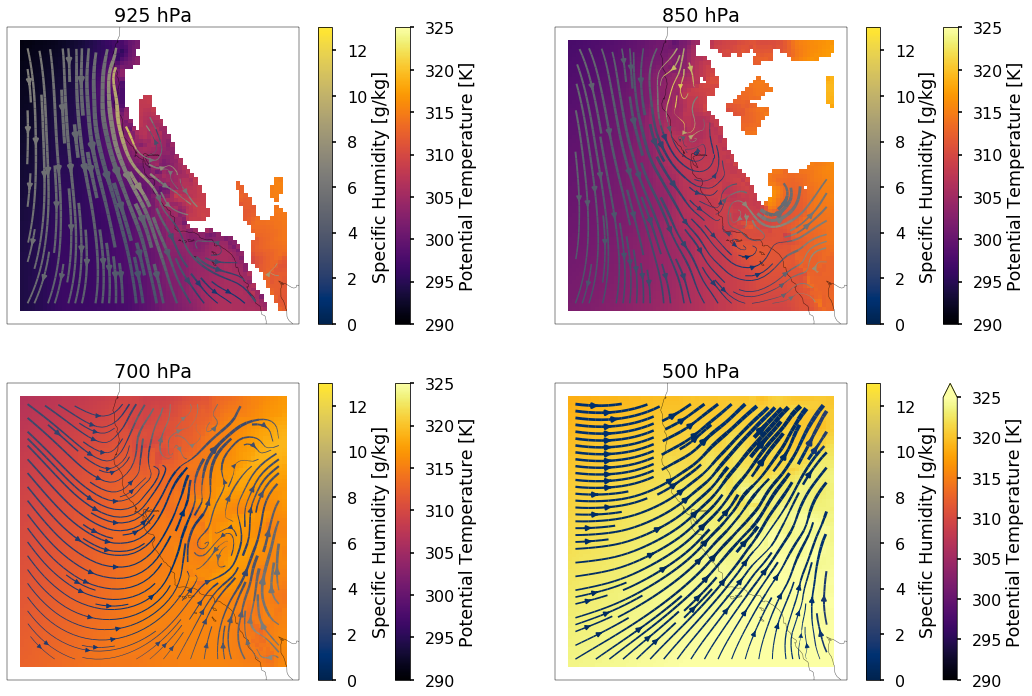

In [4]:
""" Plot the model state at multiple levels"""
fig, axs = PP.subplots(2,2,
                       figsize = (18,12),
                       subplot_kw = dict(projection = rcm_crs))

ax_list = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]
for n, plev in enumerate([925, 850, 700, 500]):
    # set the pressure level
    atm_current_plev = atm_pl_xr.sel(plev = plev)
    rad_current_plev = rad_pl_xr.sel(plev = plev)
    # get the coordinates
    x = atm_current_plev['jx'].values
    y = atm_current_plev['iy'].values
    
    # get the state variables and mask areas underground
    u = atm_current_plev['ua'].where(atm_current_plev['ps'] > plev*100).values
    v = atm_current_plev['va'].where(atm_current_plev['ps'] > plev*100).values
    q = atm_current_plev['hus'].where(atm_current_plev['ps'] > plev*100)
    t = atm_current_plev['ta'].where(atm_current_plev['ps'] > plev*100)
    qc = atm_current_plev['clw'].where(atm_current_plev['ps'] > plev*100)

    # calculate potential temperature
    theta = t*(1000/plev)**(Rd/cpd)
    theta.attrs['long_name'] = "Potential Temperature"
    theta.attrs['units'] = "K"


    ax = ax_list[n]
    theta.plot(ax = ax,
               cmap = 'inferno',
               vmin = 290,
               vmax = 325)
    #qc.plot(cmap = 'plasma')

    wspeed = np.sqrt(u**2 + v**2)
    lw = 5 * wspeed / 15
    norm = mpl.colors.Normalize(vmin = 0, vmax = 13)
    strm = ax.streamplot(x, y, u, v,
                          color = q.values*1e3,
                          cmap = 'cividis',
                          density = 1.5,
                          linewidth = lw,
                          norm = norm)

    ax.coastlines(color = 'black', resolution = '50m', alpha = 2/3)
    #ax.add_feature(cartopy.feature.STATES, edgecolor = 'black', alpha = 2/3)
#    ax.gridlines(color = 'black', alpha =, draw_labels = True) 1/3)

    fig.colorbar(strm.lines, ax = ax, label = "Specific Humidity [g/kg]")

    ax.set_aspect('auto')

    ax.set_title(f"{int(plev)} hPa")

    
PP.savefig('base_state.png', dpi = 300)
PP.show()

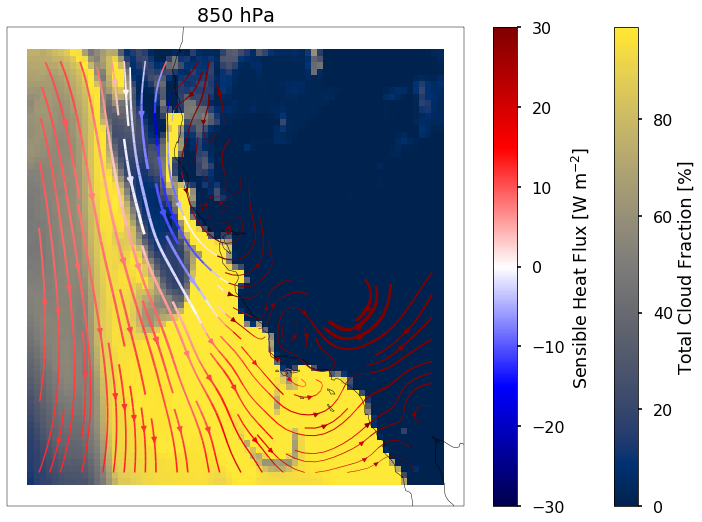

In [5]:
""" Make a plot of 850 hPa cloud cover, wind, and sensible heat flux"""

fig, ax = PP.subplots(subplot_kw = dict(projection = rcm_crs))

# plot cloud cover
srf_xr['clt'].plot(ax = ax,
                    cmap = 'cividis')

# select the pressure level
plev = 850
atm_current_plev = atm_pl_xr.sel(plev = plev)

# select the model state variables and mask areas under ground
u = atm_current_plev['ua'].where(atm_current_plev['ps'] > plev*100).values
v = atm_current_plev['va'].where(atm_current_plev['ps'] > plev*100).values
q = atm_current_plev['hus'].where(atm_current_plev['ps'] > plev*100)
t = atm_current_plev['ta'].where(atm_current_plev['ps'] > plev*100)
theta = t*(1000/plev)**(Rd/cpd)

# plot a streamplot of winds with surface heat flux as colors
wspeed = np.sqrt(u**2 + v**2)
lw = 5 * wspeed / 15 # set the line width
hfss_norm = mpl.colors.Normalize(vmin = -30, vmax = 30)
strm = ax.streamplot(x, y, u, v,
                      color = srf_xr['hfss'].values,
                      cmap = 'seismic',
                      density = 1.5,
                      norm = hfss_norm,
                      linewidth = lw)


fig.colorbar(strm.lines, ax = ax, label = "Sensible Heat Flux [W m$^{-2}$]")

ax.coastlines(color = 'black', resolution = '50m')

ax.set_aspect('auto')
ax.set_title(f"{plev} hPa")

PP.savefig('base_state_flux.png', dpi = 300)

PP.show()


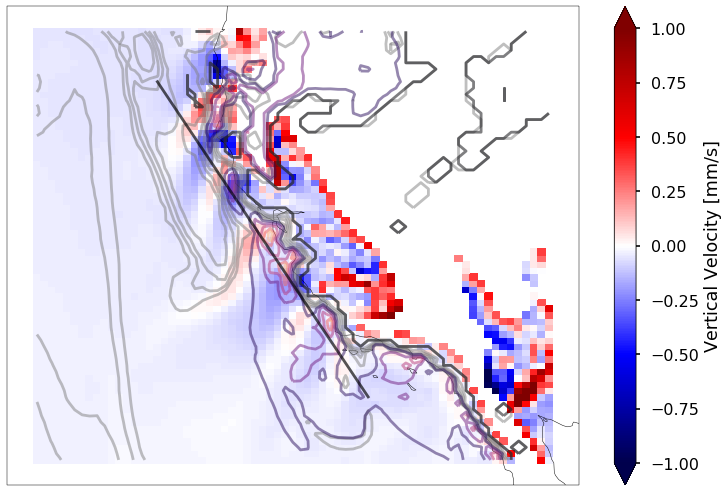

In [6]:
fig, ax = PP.subplots(subplot_kw = dict(projection = rcm_crs))


# select the pressure level
plev = 925
atm_current_plev = atm_pl_xr.sel(plev = plev)
q = atm_current_plev['hus'].where(atm_current_plev['ps'] > plev*100)
t = atm_current_plev['ta'].where(atm_current_plev['ps'] > plev*100)

# calculate air density
rho = plev*100 / (Rd * t * (1 + delta*q))
# calculate vertical velocity in mm/s
omega = atm_current_plev['omega'].where(atm_current_plev['ps'] > plev*100)
w = -1000*omega/(rho * grav)

# plot vertical velocity
w.attrs['long_name'] = 'Vertical Velocity'
w.attrs['units'] = 'mm/s'
w.plot(ax = ax,
           vmin = -1,
           vmax = 1,
           cmap = 'seismic')

# add cloud cover and cloud liquid water path
srf_xr['clt'].plot.contour(ax = ax, colors = "gray", alpha = 0.5)
rad_xr['clwp'].sum(dim = 'kz').plot.contour(ax = ax, cmap = 'magma', alpha = 0.5)


# manually set indices for the transect line
j1, i1, j2, i2 = 16,60,44,10
#j1, i1, j2, i2 = 13,60,41,10

jx1 = float(atm_pl_xr['jx'].isel(jx = j1))
jx2 = float(atm_pl_xr['jx'].isel(jx = j2))
iy1 = float(atm_pl_xr['iy'].isel(iy = i1))
iy2 = float(atm_pl_xr['iy'].isel(iy = i2))


# set the coordinate points to which we'll interpolate for the transect
m = (iy2 - iy1)/(jx2 - jx1)
b = iy1 - m*jx1

jx_interp = np.linspace(jx1, jx2, 50)
iy_interp = m*jx_interp + b


# plot the transect line
ax.plot(jx_interp, iy_interp, 'k-', alpha = 2/3)

ax.coastlines(color = 'black', resolution = '50m')

ax.set_aspect('auto')
ax.set_title("")

PP.show()

In [7]:
""" Interpolate data to the transect."""
#atm_transect = atm_xr.interp()

# set the transect coordinate (distance from northern end)
distance_max = np.sqrt((jx2-jx1)**2 + (iy2 - iy1)**2)
distance = np.linspace(0, distance_max, len(jx_interp))/1000
distance = xr.DataArray(distance, dims = 'along_coast')
distance.attrs['long_name'] = 'Distance from northern end'
distance.attrs['units'] = 'km'

# create an xarray dataarray out of the x/y coordinates to which we'll interpolate
jx_interp_da = xr.DataArray(jx_interp, dims = 'along_coast', coords = dict(along_coast = distance))
iy_interp_da = xr.DataArray(iy_interp, dims = 'along_coast')

# interpolate the model output
atm_transect = atm_xr.interp(jx = jx_interp_da, iy = iy_interp_da)
dom_transect = dom_xr.interp(jx = jx_interp_da, iy = iy_interp_da)

In [8]:
""" Calculate approximate geopotential height. """
# calculate dlog(sigma)
sigma = atm_transect['kz']
_sigma = sigma.values
sigmai = np.concatenate([[0], 0.5*(_sigma[1:] + _sigma[:-1]), [1]])
sigmai
dlnsigma = np.diff(np.log(sigmai))
# set dlogsigma to some large value at sigma = 0
dlnsigma[0] = 1e5
dlnsigma = xr.DataArray(dlnsigma, dims = 'kz', coords = dict(kz = atm_xr['kz']))

# calculate the parts of the integral (note this is approximate since sigma is the coordinate)
t = atm_transect['ta']
q = atm_transect['hus']
tv = t*(1 + delta*q)
hypsom = dlnsigma*Rd*tv/grav

#dlnp = np.log(p).diff(dim = 'kz')
flip = slice(None, None, -1)
z = hypsom.sel(kz = flip).cumsum(dim = 'kz').sel(kz = flip)

z.attrs['long_name'] = 'Height'
z.attrs['units'] = 'm'

/N/slate/obrienta/software/carbonate/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [9]:
""" Calculate some extra variables on the transects"""

# calculate pressure
ptop = float(atm_transect['ptop'])*100
p = atm_transect['kz']*(atm_transect['ps'] - ptop) + ptop

# calculate density
rho = p / (Rd * tv)

# calculate vertical velocity
omega = atm_transect['omega']
w = -1000*omega/(rho * grav)
w.attrs['long_name'] = 'Vertical Velocity'
w.attrs['units'] = 'mm/s'

# calculate potential temperature
theta = t*(1e5/p)**(Rd/cpd)

p /= 100
p.attrs['long_name'] = 'Pressure'
p.attrs['units'] = 'hPa'

theta.attrs['long_name'] = 'Potential Temperature'
theta.attrs['units'] = 'K'

rho.attrs['long_name'] = 'Density'
rho.attrs['units'] = 'kg / m$^3$'

# insert these in the transect dataset
atm_transect['w'] = w
atm_transect['p'] = p
atm_transect['theta'] = theta
atm_transect['rho'] = rho

In [10]:
""" Interpolate the transect to fixed height levels. """
# define the height coordinate
height_levels = np.arange(0,5000, 25)
height_levels = xr.DataArray(height_levels, dims = 'z')
height_levels.attrs['long_name'] = 'Height'
height_levels.attrs['units'] = 'm'

# set the variables to interpolate
interp_vars = [var for var in atm_transect.variables if atm_transect[var].dims == ('kz', 'along_coast') ]
args = tuple( atm_transect[var].values for var in interp_vars)

# do the interpolation
interpolated_vars \
            = metpy.interpolate.interpolate_1d(height_levels,
                                               z,
                                               *args,
                                                axis = 0)
# create a dataarray from the interpolated numpy arrays
da_kwargs = dict(dims = ['z','along_coast'], coords = dict(z = height_levels, along_coast = atm_transect['along_coast'] ))
atm_height_transect = xr.Dataset()
for var, interp_data in zip(interp_vars, interpolated_vars):
    atm_height_transect[var] = xr.DataArray(interp_data, **da_kwargs)
    atm_height_transect[var].attrs = atm_transect[var].attrs


/N/slate/obrienta/software/carbonate/anaconda/anaconda3/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


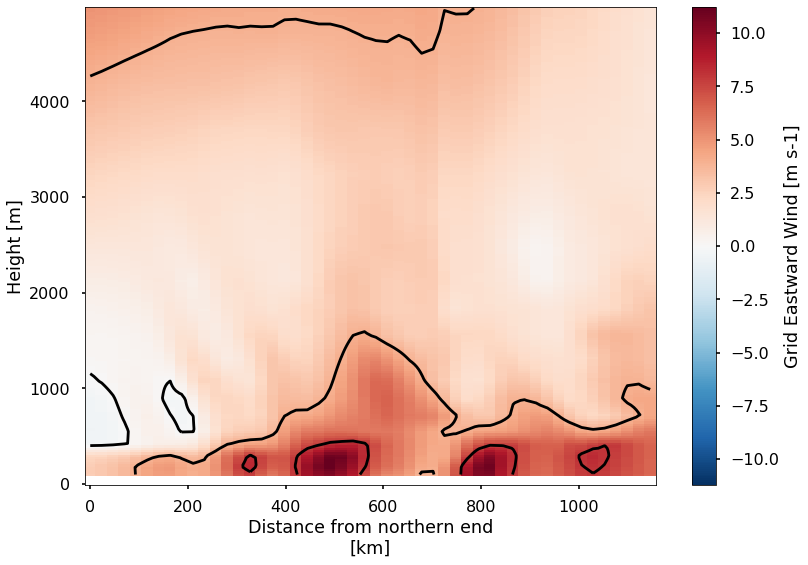

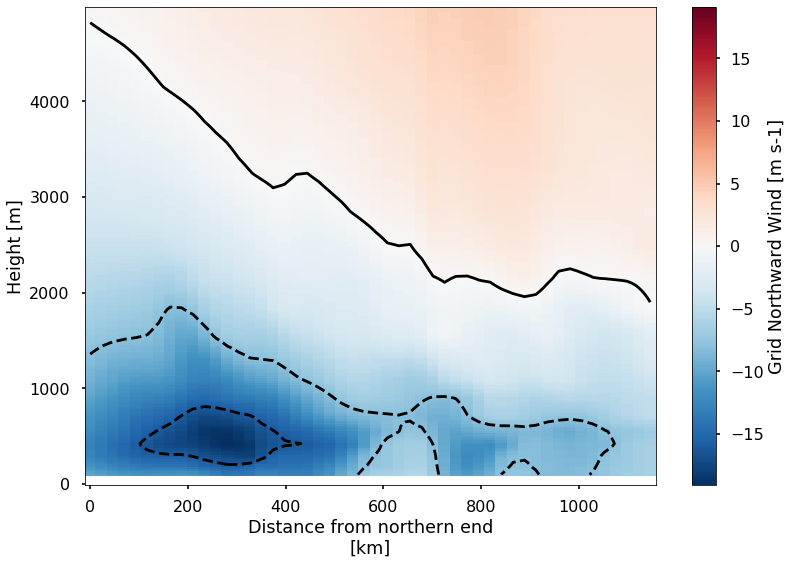

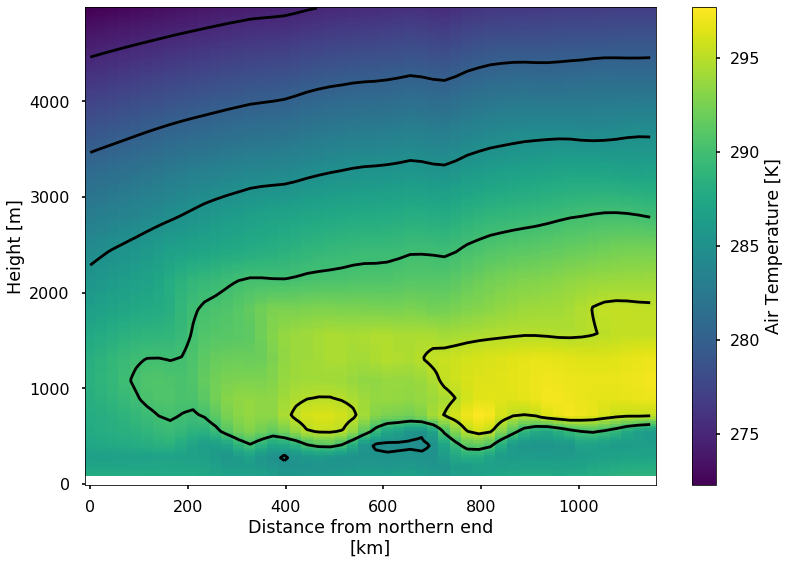

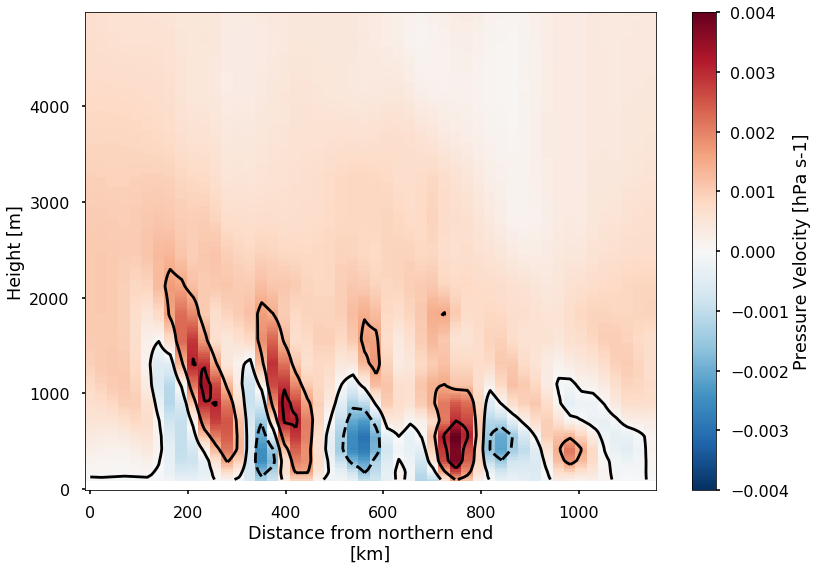

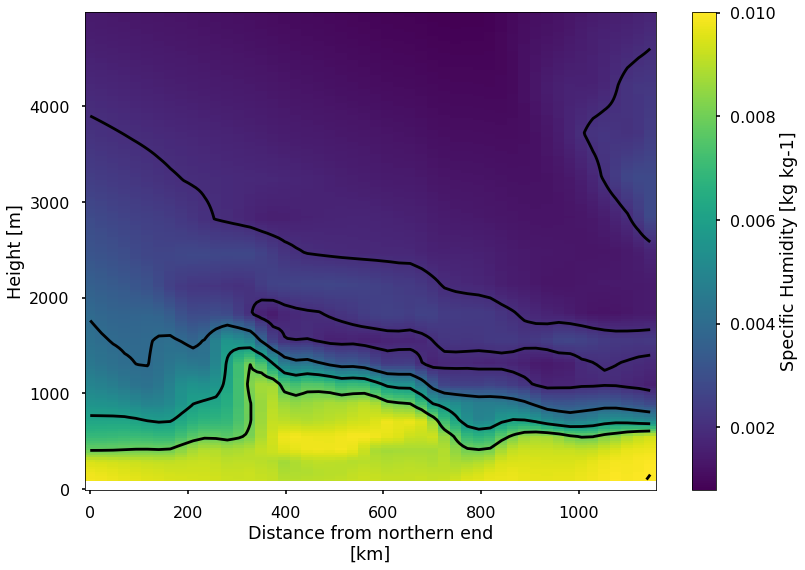

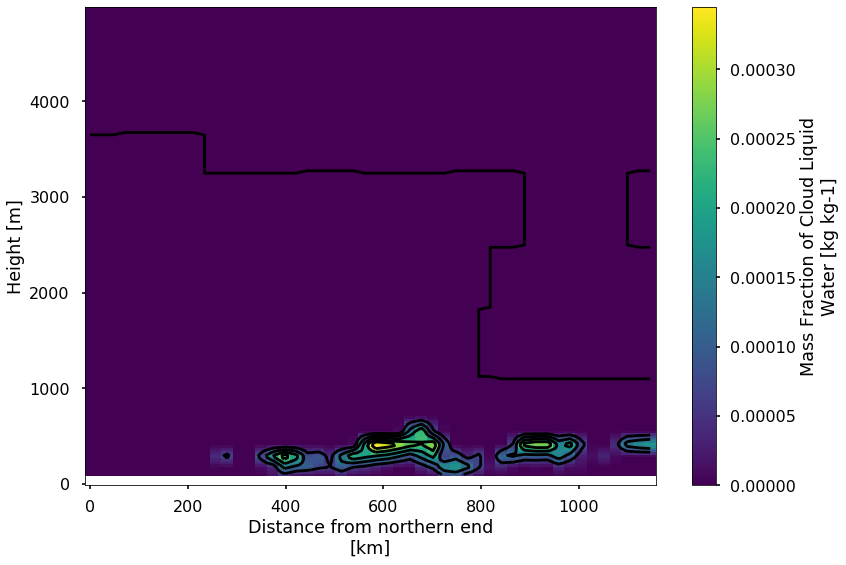

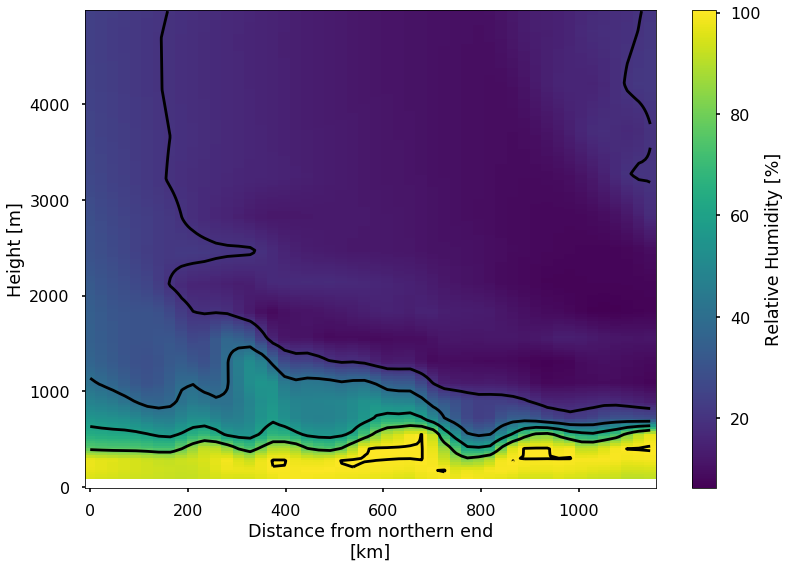

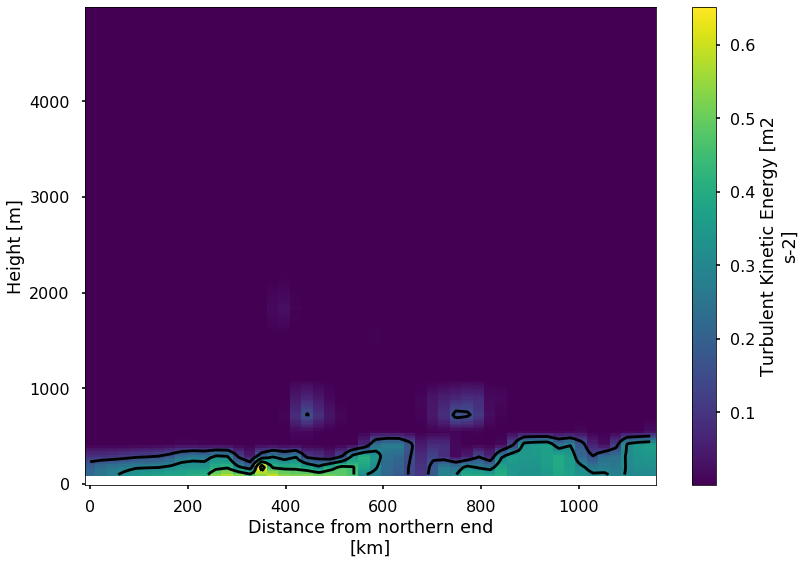

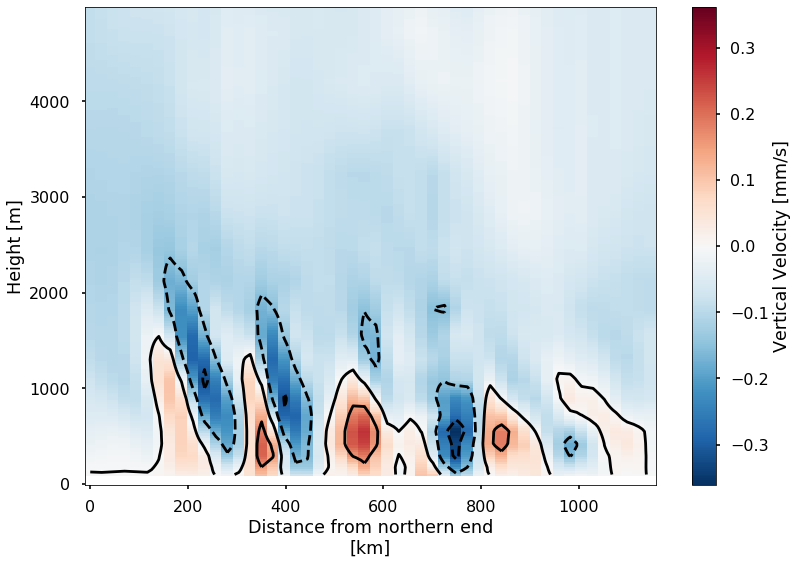

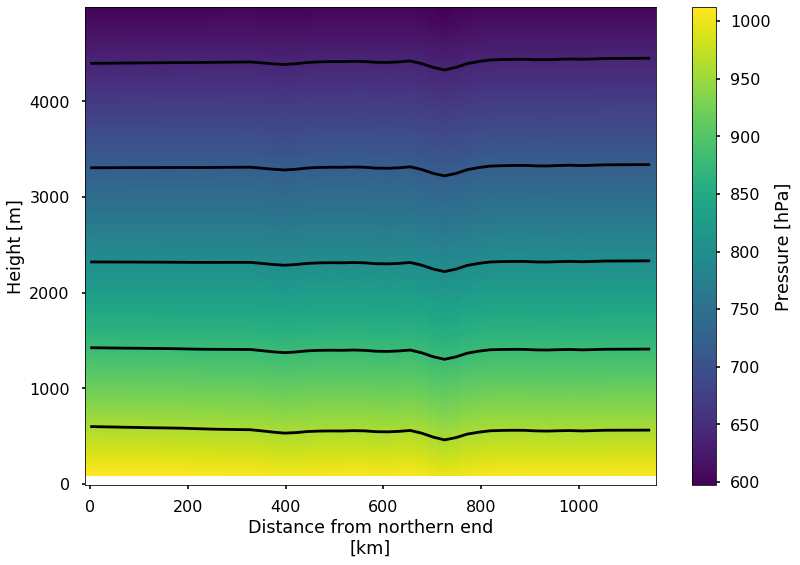

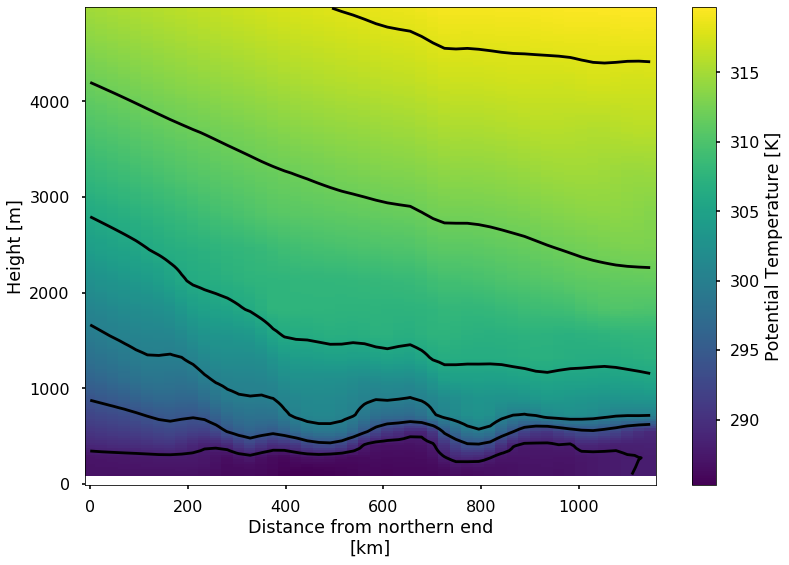

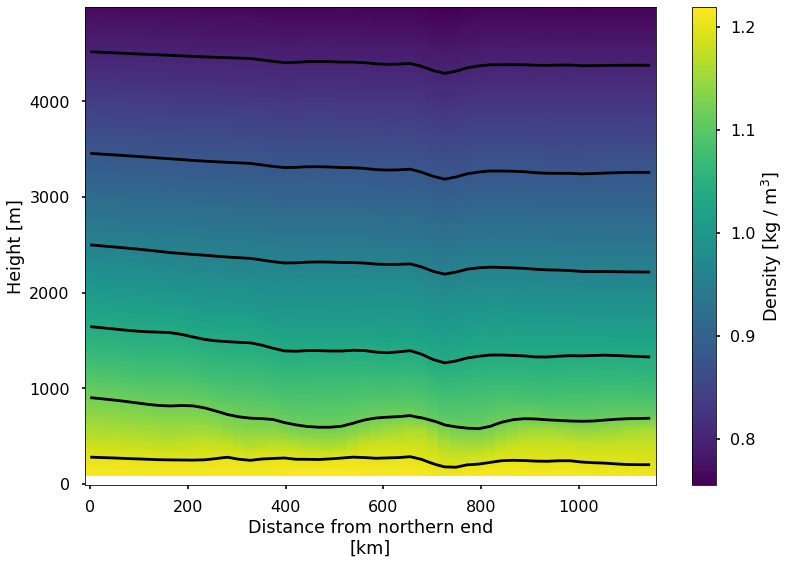

In [11]:
""" Generate transect plots for all interpolated variables. """
for var in interp_vars:
    atm_height_transect[var].plot()
    atm_height_transect[var].plot.contour(colors = 'black')
    PP.show()

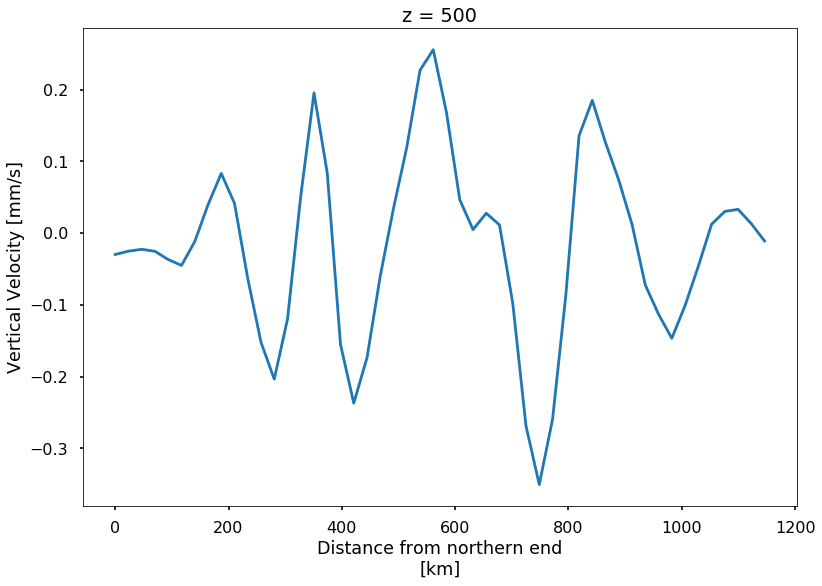

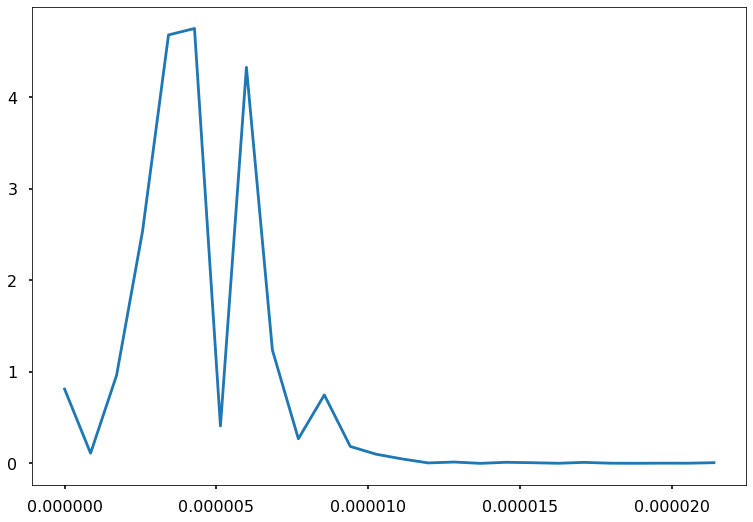

In [12]:
""" Determine the wavelength of the vertical velocity pressure wave. """
# plot w at 500 m
w500m = atm_height_transect['w'].sel(z = 500)
w500m.plot()
PP.show()

# calculate the spectrum of w 
w500m_fft = np.fft.rfft(w500m)
dx = np.diff(atm_height_transect['along_coast'].values)[0]
k_fft = np.fft.rfftfreq(len(w500m), d = dx*1000)

# plot the spectrum
w500m_spectrum = np.abs(w500m_fft)**2
PP.plot(k_fft, w500m_spectrum)
# get the peak wavelength in the spectrum
kmax = k_fft[w500m_spectrum.argmax()]
PP.show()

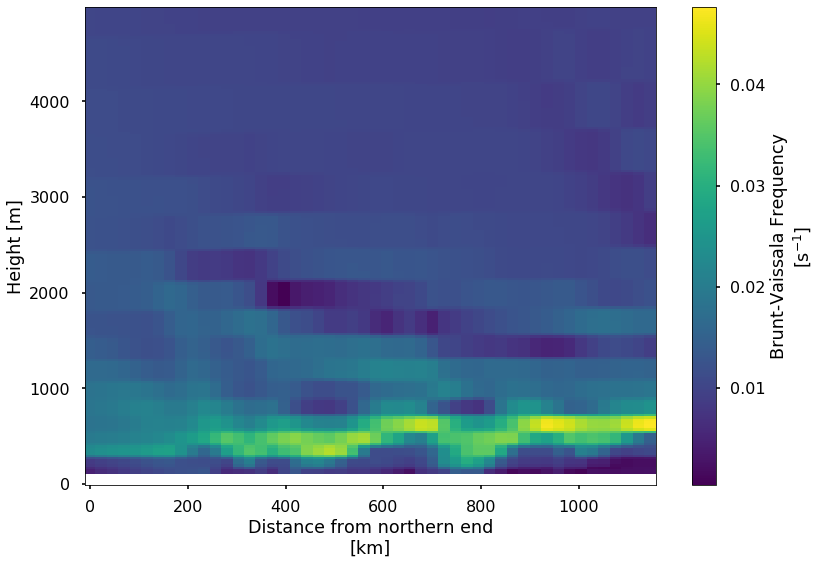

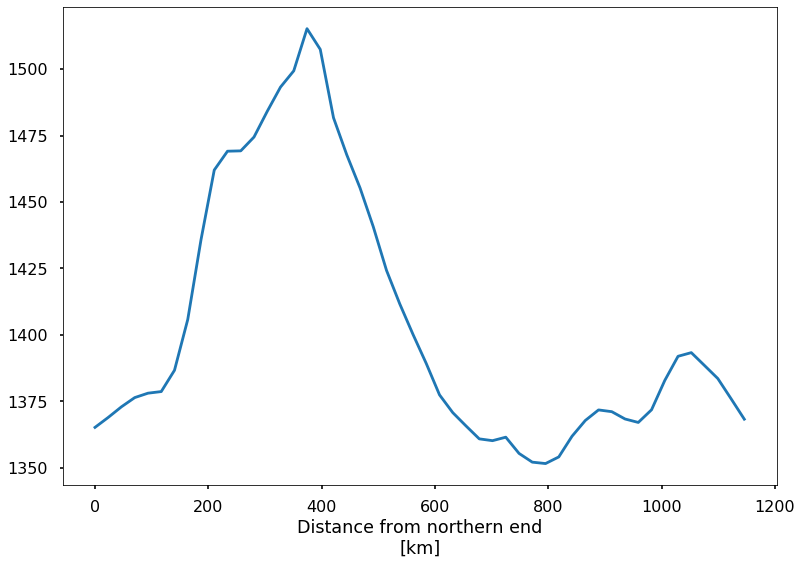

In [13]:
""" Calculate the Brunt Vaissala frequency"""
theta = atm_height_transect['theta']
dtheta_dz = theta.differentiate('z')
nsquared = np.abs((grav/theta)*dtheta_dz)
N = np.sqrt(nsquared)
N.attrs['long_name'] = "Brunt-Vaissala Frequency"
N.attrs['units'] = "s$^{-1}$"

# plot N
N.plot()
PP.show()
    
    
# calculate the rhines vertical decay scale
K = kmax
f = dom_transect['coriol']
N_avg = N.where(N.z > 2000).mean(dim = 'z')
decay_height = f/(N_avg*np.sqrt(2*K**2))

# plot the decay scale
decay_height.plot()
PP.show()
    
    

/N/slate/obrienta/software/carbonate/anaconda/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


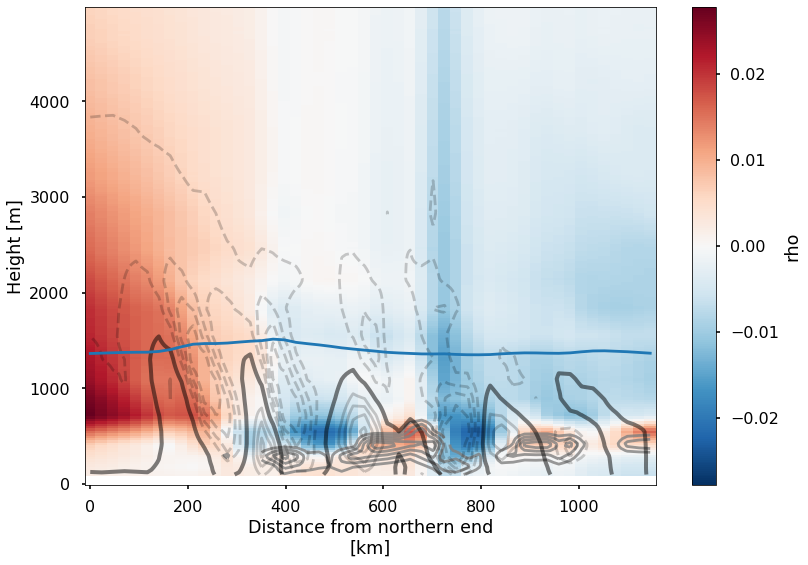

In [14]:
""" Plot vertical velocity, density anomaly, and the rhines decay scale"""
# calculate shear
dudz = atm_height_transect['ua'].differentiate('z')
dvdz = atm_height_transect['va'].differentiate('z')
shear = np.sqrt(dudz**2 + dvdz**2)
shear.attrs['long_name'] = 'Wind Shear'
shear.attrs['units'] = 's$^{-1}$'

# calculate wind speed
wspeed = np.sqrt(atm_height_transect['ua']**2 + atm_height_transect['va']**2)
wspeed.attrs['long_name'] = 'Wind Speed'
wspeed.attrs['units'] = 'm/s'

hus = atm_height_transect['hus']*1000
hus.attrs = atm_height_transect['hus'].attrs
hus.attrs['units'] = 'g/kg'
rh = atm_height_transect['rh']
theta = atm_height_transect['theta']
theta_anom = theta - theta.mean(dim = 'along_coast')
hus_anom = hus - hus.mean(dim = 'along_coast')

# calculate the density anomaly
rho = atm_height_transect['rho']
rho_anom = rho - rho.mean('along_coast')

fig, ax = PP.subplots()
#hus.plot(ax = ax)
#rh.plot(ax = ax,
#        cmap = 'cividis_r')
rho_anom.plot(ax = ax)
#hus_anom.plot()
#wspeed.plot()
#theta.plot()

# extract cloud water
clw = atm_height_transect['clw']
clw.where(clw > 1e-6).plot.contour(colors = 'gray', alpha = 0.8)

# plot contours of w
wlevels = [-0.25, -0.2, -0.15, -0.1, 0, 0.1, 0.15, 0.2, 0.25]
izero = wlevels.index(0)
cplt = atm_height_transect['w'].plot.contour(colors = 'black',
                                      levels = wlevels,
                                      alpha = 0.2)
# plot the 0-line with a thick contour
cplt.collections[izero].set_linewidth(4)
cplt.collections[izero].set_alpha(0.5)

# plot the decay scale
decay_height.plot(ax = ax)

ax.set_ylabel("Height [m]")

PP.show()


/N/slate/obrienta/software/carbonate/anaconda/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


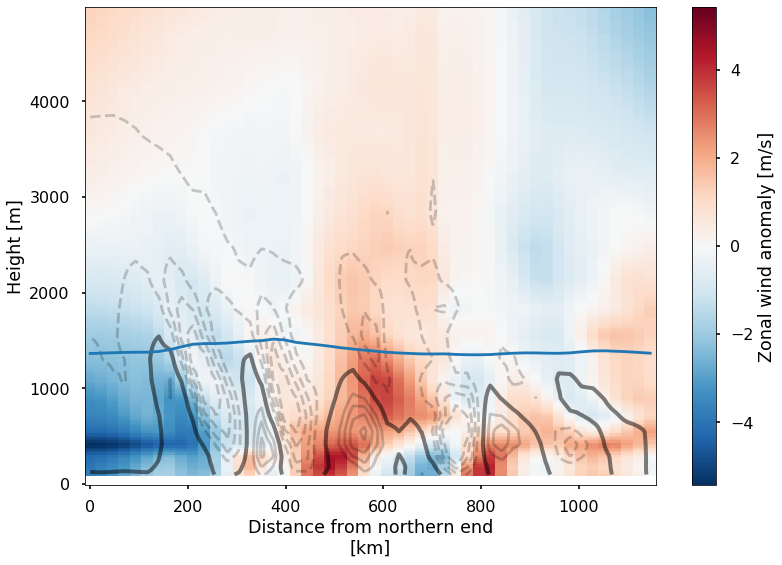

In [15]:
# calculate shear
dudz = atm_height_transect['ua'].differentiate('z')
dvdz = atm_height_transect['va'].differentiate('z')
shear = np.sqrt(dudz**2 + dvdz**2)
shear.attrs['long_name'] = 'Wind Shear'
shear.attrs['units'] = 's$^{-1}$'

wspeed = np.sqrt(atm_height_transect['ua']**2 + atm_height_transect['va']**2)
wspeed.attrs['long_name'] = 'Wind Speed'
wspeed.attrs['units'] = 'm/s'

hus = atm_height_transect['hus']*1000
hus.attrs = atm_height_transect['hus'].attrs
hus.attrs['units'] = 'g/kg'
rh = atm_height_transect['rh']
theta = atm_height_transect['theta']
theta_anom = theta - theta.mean(dim = 'along_coast')
hus_anom = hus - hus.mean(dim = 'along_coast')

# calculate the wind speed anomaly
u = atm_height_transect['ua']
u_anom = u - u.mean(dim = 'along_coast')
u_anom.attrs['long_name'] = 'Zonal wind anomaly'
u_anom.attrs['units'] = 'm/s'

fig, ax = PP.subplots()
# plot the wind anomaly
u_anom.plot(ax = ax)

# plot vertical velocity
wlevels = [-0.25, -0.2, -0.15, -0.1, 0, 0.1, 0.15, 0.2, 0.25]
izero = wlevels.index(0)
cplt = atm_height_transect['w'].plot.contour(colors = 'black',
                                      levels = wlevels,
                                      alpha = 0.2)
cplt.collections[izero].set_linewidth(4)
cplt.collections[izero].set_alpha(0.5)

# plot the decay scale
decay_height.plot(ax = ax)

ax.set_ylabel("Height [m]")



PP.show()


/N/slate/obrienta/software/carbonate/anaconda/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


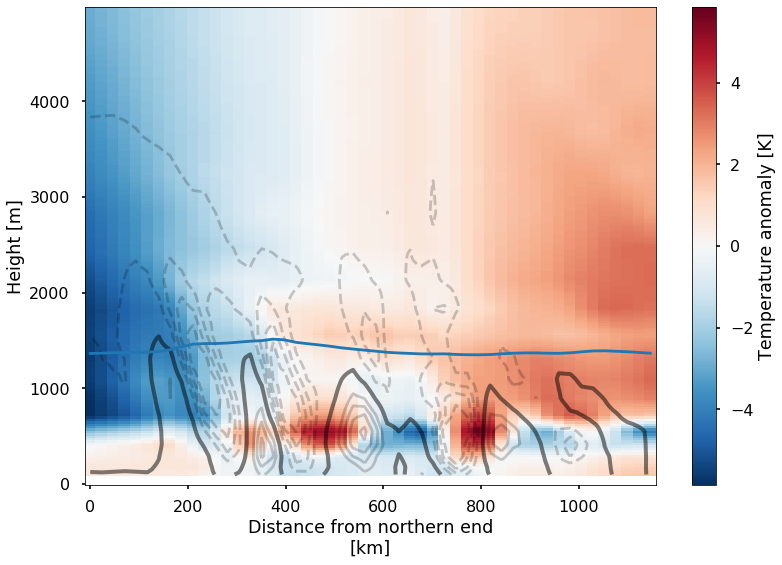

In [18]:
# calculate shear
dudz = atm_height_transect['ua'].differentiate('z')
dvdz = atm_height_transect['va'].differentiate('z')
shear = np.sqrt(dudz**2 + dvdz**2)
shear.attrs['long_name'] = 'Wind Shear'
shear.attrs['units'] = 's$^{-1}$'

wspeed = np.sqrt(atm_height_transect['ua']**2 + atm_height_transect['va']**2)
wspeed.attrs['long_name'] = 'Wind Speed'
wspeed.attrs['units'] = 'm/s'

hus = atm_height_transect['hus']*1000
hus.attrs = atm_height_transect['hus'].attrs
hus.attrs['units'] = 'g/kg'
rh = atm_height_transect['rh']
theta = atm_height_transect['theta']
theta_anom = theta - theta.mean(dim = 'along_coast')
hus_anom = hus - hus.mean(dim = 'along_coast')

# calculate the wind speed anomaly
u = atm_height_transect['ta']
u_anom = u - u.mean(dim = 'along_coast')
u_anom.attrs['long_name'] = 'Temperature anomaly'
u_anom.attrs['units'] = 'K'

fig, ax = PP.subplots()
# plot the wind anomaly
u_anom.plot(ax = ax)

# plot vertical velocity
wlevels = [-0.25, -0.2, -0.15, -0.1, 0, 0.1, 0.15, 0.2, 0.25]
izero = wlevels.index(0)
cplt = atm_height_transect['w'].plot.contour(colors = 'black',
                                      levels = wlevels,
                                      alpha = 0.2)
cplt.collections[izero].set_linewidth(4)
cplt.collections[izero].set_alpha(0.5)

# plot the decay scale
decay_height.plot(ax = ax)

ax.set_ylabel("Height [m]")



PP.show()


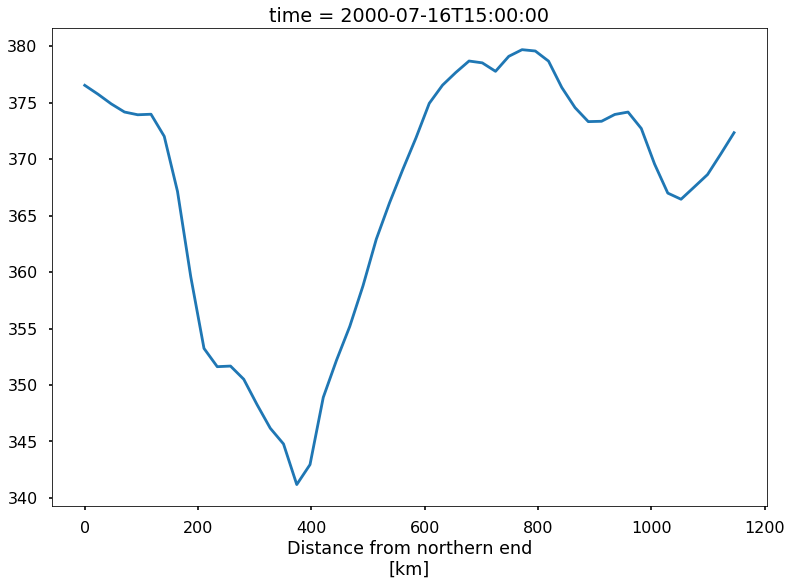

In [17]:
# calculate the atmospheric scale height
zh = (Rd*grav/atm_transect['ts'])
# calculate the rossby Radius
Ld = N_avg*zh/(np.pi*f)
Ld.plot()

ax.set_ylabel("Rossby Radius of Deofrmation [km]")

PP.show()